# MLP Regression on Cantilever beam data.

**Step 1: Split the data into Training, Validation and Testing sets** 

In [ ]:
pip install pandas scikit-learn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv("collocation_linear.csv")

X = df[["x", "y"]].values #input values
y = df[["u_x", "u_y"]].values #output values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size = 2/9, random_state=42
)

print(X_test.shape)
print(X_train.shape)
print(X_val.shape)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) #fit on train data

X_val_scaled = scaler.transform(X_val) #apply same transform on val and test data
X_test_scaled = scaler.transform(X_test)



**Step 2: Hyperparameter Search**

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np 

# Using GridSearchCV (3-fold CV on training+validation) to explore:
X_trainval = np.vstack((X_train_scaled, X_val_scaled))
print(X_trainval.shape)
y_trainval = np.vstack((y_train,y_val))
print(y_trainval.shape)

# Define model
mlp = MLPRegressor(hidden_layer_sizes=(64,64),max_iter=5000,random_state=42)

param_grid = {
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant'],
    'learning_rate_init': [1e-6, 1e-4, 1e-2],
    'activation': ['relu', 'tanh'],
    'tol': [1e-8]
}

# perform gridsearch
grid_search = GridSearchCV(mlp, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_trainval,y_trainval)

# === Extract Results into Summary Table ===
results_df = pd.DataFrame(grid_search.cv_results_)
summary_table = results_df[[
    'param_solver', 'param_activation', 'param_learning_rate',
    'param_learning_rate_init', 'param_tol',
    'mean_test_score', 'rank_test_score'
]].copy()

summary_table['mean_validation_MSE'] = -summary_table['mean_test_score']
summary_table.drop(columns='mean_test_score', inplace=True)
summary_table.sort_values(by='mean_validation_MSE', inplace=True)

# === Print Best Result ===
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print("\n Best Hyperparameters:")
for key, val in best_params.items():
    print(f"  {key}: {val}")
print(f"\n Best Validation MSE: {best_mse:.6f}")

# === Optional: Save to CSV or Print LaTeX Table ===
summary_table.to_csv("gridsearch_results.csv", index=False)

# For LaTeX report (optional)
print("\n LaTeX Table Preview:")
print(summary_table.head().to_latex(index=False, float_format="%.3e"))

**Step 3: Break-even Analysis**

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

training_size = [50, 100, 200, 300, 350]

mlp_mse = []
nearest_mse = []
linear_mse = []
cubic_mse = []

for n in training_size:
    np.random.seed(42)
    idx = np.random.choice(X_train.shape[0], size=n, replace=False)

    X_sample = X_train[idx]
    y_sample = y_train[idx]
    X_sample_scaled = scaler.transform(X_sample)
    X_test_scaled = scaler.transform(X_test)

    # MLP model
    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation=best_params['activation'],
        learning_rate=best_params['learning_rate'],
        learning_rate_init=best_params['learning_rate_init'],
        tol=best_params['tol'],
        solver=best_params['solver'],
        max_iter=5000,
        random_state=42
    )
    mlp.fit(X_sample_scaled, y_sample)
    y_pred_mlp = mlp.predict(X_test_scaled)
    mlp_mse.append(mean_squared_error(y_test, y_pred_mlp))

    # Interpolation methods (same X_sample as MLP)
    for method, mse_list in zip(['nearest', 'linear', 'cubic'], [nearest_mse, linear_mse, cubic_mse]):
        try:
            y_interp = []
            for i in range(2):  # ux, uy
                interp_result = griddata(
                    points=X_sample,
                    values=y_sample[:, i],
                    xi=X_test,
                    method=method,
                    fill_value=0.0
                )
                y_interp.append(interp_result)
            y_interp = np.stack(y_interp, axis=-1)
            mse = mean_squared_error(y_test, y_interp)
        except Exception:
            mse = np.nan
        mse_list.append(mse)

print("MLP MSEs:", mlp_mse)
print("Nearest MSEs:", nearest_mse)
print("Linear MSEs:", linear_mse)
print("Cubic MSEs:", cubic_mse)

**Step 4: Plotting**

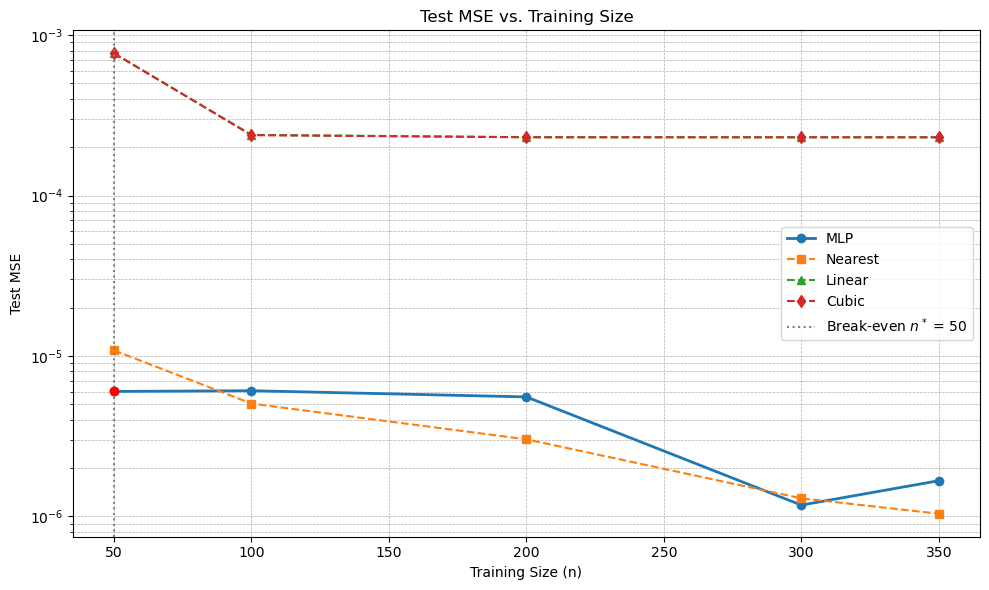

In [37]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(training_size, mlp_mse, marker='o', label='MLP', linewidth=2)
plt.plot(training_size, nearest_mse, marker='s', label='Nearest', linestyle='--')
plt.plot(training_size, linear_mse, marker='^', label='Linear', linestyle='--')
plt.plot(training_size, cubic_mse, marker='d', label='Cubic', linestyle='--')

# Break-even point
for i in range(len(training_size)):
    if mlp_mse[i] < min(nearest_mse[i], linear_mse[i], cubic_mse[i]):
        plt.axvline(x=training_size[i], color='gray', linestyle=':', label=f'Break-even $n^*$ = {training_size[i]}')
        plt.scatter([training_size[i]], [mlp_mse[i]], color='red', zorder=5)
        break

plt.xlabel("Training Size (n)")
plt.ylabel("Test MSE")
plt.yscale("log")
plt.title("Test MSE vs. Training Size")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("break_even_plot_corrected.png", dpi=300)
plt.show()